In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [3]:
user = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Funnel_Analysis/user_table.csv')

In [4]:
user.head(1)

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female


In [8]:
user.shape

(90400, 4)

In [5]:
home_page = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Funnel_Analysis/home_page_table.csv')

In [7]:
home_page.head(1)

,user_id,page
0,313593,home_page


In [9]:
home_page.shape

(90400, 2)

In [10]:
search_page = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Funnel_Analysis/search_page_table.csv')

In [11]:
search_page.head(1)

,user_id,page
0,15866,search_page


In [12]:
search_page.shape

(45200, 2)

In [13]:
payment_page = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Funnel_Analysis/payment_page_table.csv')

In [14]:
payment_page.head(1)

,user_id,page
0,253019,payment_page


In [15]:
payment_page.shape

(6030, 2)

In [16]:
payment_confirmation = pandas.read_csv('/Users/christie/Documents/udemy-course/Refactored_Py_DS_ML_Bootcamp-master/productCourse/dataset/Funnel_Analysis/payment_confirmation_table.csv')

In [17]:
payment_confirmation.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


In [18]:
payment_confirmation.shape

(452, 2)

In [19]:
#join all of them on user_id
data=pandas.merge(user,home_page,how='left',on='user_id')

In [20]:
data=pandas.merge(data,search_page,how='left',on='user_id',suffixes=('_home','_search'))

In [21]:
data.head(1)

,user_id,date,device,sex,page_home,page_search
0,450007,2015-02-28,Desktop,Female,home_page,NaN


In [22]:
data=pandas.merge(data,payment_page,how='left',on='user_id')

In [25]:
data=pandas.merge(data,payment_confirmation,how='left',on='user_id',suffixes=('_payment','_confirmation'))

In [26]:
data.head(1)

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN


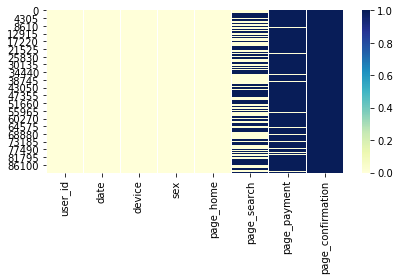

In [27]:
sns.heatmap(data.isnull(),cmap = 'YlGnBu')

In [28]:
#Replace NAs with 0 and non-NAs with 1
for i in range(4,8):
    data.iloc[:,i] = np.where(data.iloc[:,i].isna(), 0, 1)

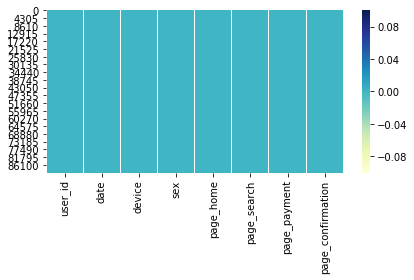

In [29]:
# isnull() vs isna()  ???
sns.heatmap(data.isnull(),cmap = 'YlGnBu')

In [30]:
data.head(1)

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,1,0,0,0


In [35]:
data.dtypes

user_id                       int64
date                 datetime64[ns]
device                       object
sex                          object
page_home                     int64
page_search                   int64
page_payment                  int64
page_confirmation             int64
dtype: object

In [34]:
data['date'] = pandas.to_datetime(data['date'])

In [36]:
data.describe()

,user_id,page_home,page_search,page_payment,page_confirmation
count,90400.000000,90400.0,90400.000000,90400.000000,90400.000000
mean,498709.683473,1.0,0.500000,0.066704,0.005000
std,289040.674085,0.0,0.500003,0.249509,0.070534
min,17.000000,1.0,0.000000,0.000000,0.000000
25%,247978.750000,1.0,0.000000,0.000000,0.000000
50%,498267.000000,1.0,0.500000,0.000000,0.000000
75%,749789.250000,1.0,1.000000,0.000000,0.000000
max,999979.000000,1.0,1.000000,1.000000,1.000000


In [37]:
#Check data reliability. Are user_ids unique?
print(data['user_id'].nunique()==len(data))

True


In [38]:
#Anyone who made it to a given step of the funnel also made it to the prior step(s)? I.e., if a user got to the payment_page, were they also in the search_page? They should! 
#check payment_page vs search_page
print((data['page_search'] >= data['page_payment']).unique())

[ True]


In [39]:
print((data['page_payment'] >= data['page_confirmation']).unique())

[ True]


In [40]:
print(data.groupby('device')['page_confirmation'].agg({'mean', 'count'}))

         count      mean
device                  
Desktop  60200  0.002492
Mobile   30200  0.010000


In [41]:
#Let's check the entire funnel
print(data.groupby('device').apply(
                    lambda x: pandas.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  }))
)

         to_search  to_payment  to_confirmation
device                                         
Desktop        0.5         0.1         0.049834
Mobile         0.5         0.2         0.100000


In [42]:
#Conversion rate as a time series
cr_ts = data.groupby(['date', 'device'])['page_confirmation'].mean().reset_index(name='conversion_rate')

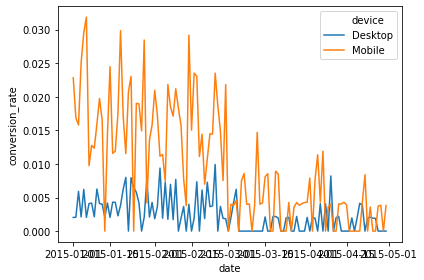

In [43]:
g = sns.lineplot(x="date", hue="device", y="conversion_rate", data=cr_ts)  

In [44]:
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [45]:
plt.show()

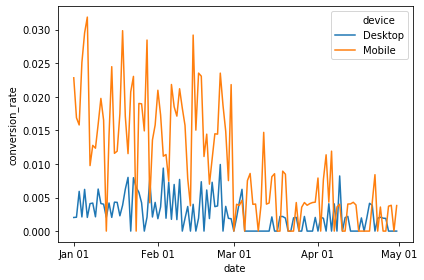

In [47]:
g = sns.lineplot(x="date", hue="device", y="conversion_rate", data=cr_ts)
g.xaxis.set_major_locator(mdates.MonthLocator())
g.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [48]:
#funnel as a time series
funnel = data.groupby(['date', 'device']).apply(
                    lambda x: pandas.Series({
                            'to_search' : x['page_search'].mean()/x['page_home'].mean(),
                            'to_payment': x['page_payment'].mean()/x['page_search'].mean(),
                            'to_confirmation': x['page_confirmation'].mean()/x['page_payment'].mean()
  })).reset_index()
  
#Make the dataset long for the plot
funnel = pandas.melt(funnel,id_vars=['date', 'device'])

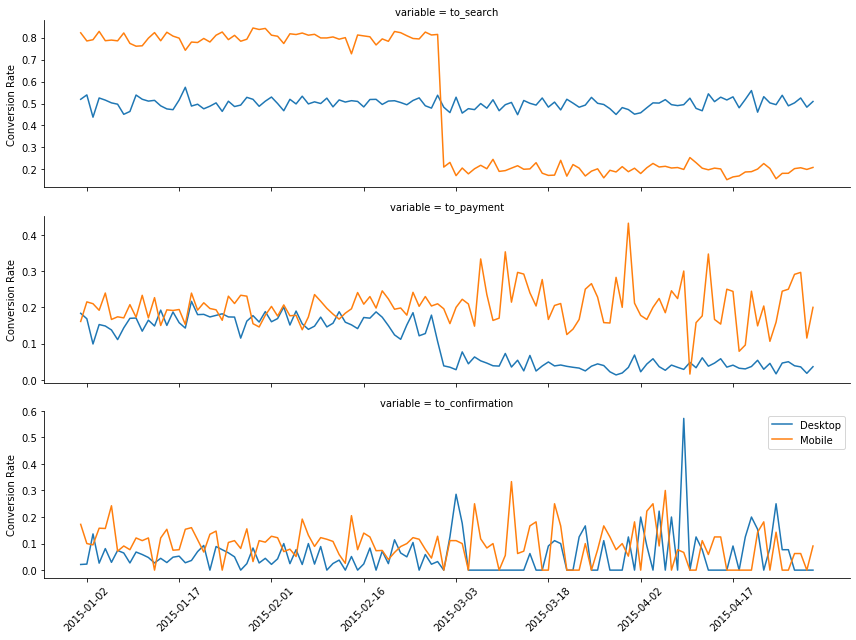

In [50]:
#Plot it
g = sns.FacetGrid(funnel, hue="device", row="variable", aspect=4, sharey=False)
g.map(sns.lineplot, "date", "value")
g.set_axis_labels("", "Conversion Rate")
g.set(xticks=funnel.date[2::30].unique())
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

In [51]:
print(data.groupby('sex')['page_confirmation'].agg({'mean', 'count'}))

        count      mean
sex                    
Female  45075  0.005347
Male    45325  0.004655


In [52]:
from scipy import stats
#Statisitical test on conversion rate and sex

In [53]:
test = stats.ttest_ind(data.loc[data['sex'] == 'Female']['page_confirmation'], data.loc[data['sex'] != 'Female']['page_confirmation'], equal_var=False)

In [54]:
print(test.statistic)

1.473291657657286


In [55]:
print(test.pvalue)

0.14067591026227633


In [56]:
print(data.groupby(['device', 'sex'])['page_confirmation'].agg({'mean', 'count'}))

                count      mean
device  sex                    
Desktop Female  29997  0.002467
        Male    30203  0.002516
Mobile  Female  15078  0.011076
        Male    15122  0.008927
